In [138]:
from langchain_groq import ChatGroq
from langgraph.graph import StateGraph, START, END
from langsmith import traceable
from langchain_community.tools.tavily_search import TavilySearchResults
from typing import Annotated,TypedDict,Literal,Dict,List,Any
from pydantic import BaseModel,Field
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage,BaseMessage
from dotenv import load_dotenv
from langgraph.graph.message import add_messages
from langgraph.prebuilt import create_react_agent,tools_condition,ToolNode
from langchain_core.tools import tool
from langgraph_supervisor import create_supervisor,create_handoff_tool
from datetime import datetime,timedelta
from sec_api import QueryApi
from sec_edgar_api import EdgarClient
import os
import sqlite3
import requests
load_dotenv()


True

In [110]:
model=ChatGroq(api_key=os.getenv("GROQ"),model="llama3-8b-8192")

In [111]:

class Sentiment(BaseModel):
    sentiment:Literal['positive','negative','neutral']=Field(...,description="you need to classify the sentiment of the message based on the analysis")
    reason:str =Field(...,description="you need to give the reason for the sentiment classification")
    overall_factors:Dict[str,str]=Field(...,description="Factors influencing the sentiment in which the key is sentiment and reason is the value")

In [112]:
class reason_setiment(BaseModel):
    overall_sentiment:Literal['positive','negative','neutral']=Field(...,description="you need to classify the sentiment of the message based on the analysis")
    analysis: Annotated[List[Point], Field(min_items=1, description="List of bullet points explaining the sentiment classification.")] 


In [113]:
model2_wstr_output=model.with_structured_output(reason_setiment)

In [114]:
model_with_structure=model.with_structured_output(Sentiment)

In [115]:
class StockAgent(TypedDict):
    ticker:str
    message:Annotated[list,add_messages]

In [122]:
def search_web(query:str):
   ''' Searches the web for the given query and returns the top 10 results '''
   tavily=TavilySearchResults(max_results=20,api_key=os.getenv('TAVILY_API_KEY'))
   return tavily.invoke(query)


In [133]:
import os
from sec_api import QueryApi # Changed from EdgarClient
from bs4 import BeautifulSoup
import requests # Added import

# IMPORTANT: The SEC API requires you to set a User-Agent.
# Replace 'Your Name' and 'your.email@example.com' with your actual info.
os.environ['EDGAR_USER_AGENT'] = 'Divy yadavdipu296@gmail.com'
@tool(description="Fetches the full text of the most recent 10-K filing for a given company ticker using sec_api.QueryApi.")
def get_latest_10k_filing(ticker: str) -> str:
    """
    Fetches the full text of the most recent 10-K filing for a given company ticker using sec_api.QueryApi.

    Args:
        ticker: The company's stock ticker (e.g., "TSLA").

    Returns:
        The plain text content of the 10-K filing's primary document.
        Returns an error message if the filing cannot be fetched.
    """
    print(f"---  SEC TOOL: Fetching latest 10-K for {ticker} ---")
    try:
        # Initialize QueryApi with your SEC API key
        query_api = QueryApi(api_key=os.getenv('SEC_API_KEY')) # Assumes SEC_API_KEY in .env

        # Query for the latest 10-K filing for the ticker
        query = {
        "query": {"query_string": {"query": f'ticker:{ticker} AND formType:"10-K"'}},
        "from": 0,
        "size": 1,
        "sort": [{"filedAt": {"order": "desc"}}],
    }
        response = query_api.get_filings(query=query)
        
        if not response or not response.get("filings"):
            return f"Error: No 10-K filings found for ticker {ticker}."

        # Get the URL of the primary document from the latest filing
        filing_url = response["filings"][0].get("linkToHtml")
        
        if not filing_url:
            return f"Error: Could not find a filing URL for {ticker}."

        # Fetch the content of the filing URL using requests
        filing_html = requests.get(filing_url, headers={'User-Agent': os.getenv('EDGAR_USER_AGENT')}).text

        # Use BeautifulSoup to parse the HTML and extract all text
        soup = BeautifulSoup(filing_html, 'html.parser')
        plain_text = soup.get_text(separator='\n', strip=True)

        print(f"--- SEC TOOL: Successfully fetched and parsed 10-K for {ticker}. ---")
        return plain_text

    except Exception as e:
        return f"An error occurred while fetching the SEC data: {e}"

In [139]:
@tool(description="Searches the web for the the ticker and gives the result sentiment with analysis")
def analyze_news_sentiment(ticker:str,days_back:int=30)-> Dict[str, Any]:
                    """
                    Analyzes recent news sentiment for a given company ticker over a specified period.
                    
                    Args:
                        ticker: The company's stock ticker (e.g., "TSLA").
                        days_back: Number of days to look back for news articles (default: 30).
                        
                    Returns:
                        A dictionary containing news sentiment analysis.
                    """
                    try:
                        end_date=datetime.now()
                        start_date=end_date-timedelta(days=days_back)
                        search_query = f"{ticker} company news from {start_date.strftime('%Y-%m-%d')} to {end_date.strftime('%Y-%m-%d')} of its performances and changes"
                        news_result= search_web(search_query)
                        if not news_result:
                            return {'error':f" no articles found for the ticker {ticker} for the specific period"}
                        news_text=''
                        for i,result in enumerate(news_result[:10],1):
                            news_text += f"Article {i}: {result.get('title', 'No title')}\n"
                            news_text += f"Content: {result.get('content', 'No content')[:200]}...\n\n"
                    except Exception as e:
                        raise {'error':f"An error occurred while fetching news articles: {e}"}
                    sentiment_result=model_with_structure.invoke(news_text)
                    prompt=f"based on the {sentiment_result} provide a summary of the news sentiment with detailed reasons from the news text"
                    final_sentiment_with_reason=model2_wstr_output.invoke(prompt)
                    return final_sentiment_with_reason

In [ ]:
tools=[get_latest_10k_filing,search_web]

In [ ]:
tool_model=model.bind_tools(tools=tools)

In [ ]:
tool_node=ToolNode(tools=tools,messages_key='message')

In [ ]:
def smart_llm(state:StockAgent):
    ticker=state['ticker']
    llm_input = state.get('message', []) + [SystemMessage(
        content=' u are an expert finance model'),HumanMessage(content=f"Give me a summary of the latest 10-K filing for {ticker} and any other relevant information.")]
    response_message = tool_model.invoke(llm_input)
    return {'message': [response_message]}

def tool_router(state: StockAgent):
    last_message=state['message'][-1]
    if hasattr(last_message, 'tool_calls') and len(last_message.tool_calls) > 0:
        return 'tool'
    return 'end'

In [ ]:
graph=StateGraph(StockAgent)
graph.add_node('agent',smart_llm)
graph.add_node('tool',tool_node)
graph.set_entry_point('agent')  

graph.add_conditional_edges('agent',tool_router,{'tool':'tool','end':END})
graph.add_edge('tool','agent')

workflow=graph.compile()

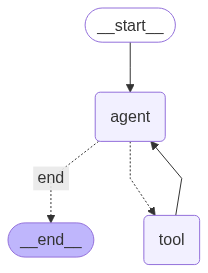

In [ ]:
workflow

In [ ]:
initial_state={'ticker':'MSFT', 'message': []}

response=workflow.invoke(initial_state)

---  SEC TOOL: Fetching latest 10-K for MSFT ---
--- SEC TOOL: Successfully fetched and parsed 10-K for MSFT. ---


In [137]:
# 1. Junior Agents (Specialized Analysts)
financial_analyst = create_react_agent(
    model=model,
    tools=[get_latest_10k_filing],
    name='financial_analyst',
    prompt='''You are a Junior Financial Analyst. Your job is to:
    1. Fetch and analyze the latest 10-K filing
    2. Extract key financial metrics, risk factors, and business insights
    3. Provide a structured financial summary
    4. Be thorough but concise - senior analysts will review your work'''
)

news_analyst = create_react_agent(
    model=model,
    tools=[search_web, analyze_news_sentiment],
    name='news_analyst',
    prompt='''You are a Junior News Analyst. Your job is to:
    1. Search for recent news about the given ticker
    2. Analyze sentiment and identify key drivers
    3. Provide market sentiment score and news summary
    4. Be objective and data-driven'''
)

technical_analyst = create_react_agent(
    model=model,# Will add yfinance tools later
    name='technical_analyst',
    prompt='''You are a Junior Technical Analyst. Your job is to:
    1. Analyze stock price data and technical indicators
    2. Identify trends, support/resistance levels, and momentum
    3. Provide technical outlook with confidence level
    4. Note: Currently placeholder - will add stock data tools'''
)

# 2. Senior Supervisor Agent (Portfolio Manager)
# Create supervisor that can hand off to specialized agents
supervisor = create_supervisor(
    model=model,
    agents={
        'financial_analyst': financial_analyst,
        'news_analyst': news_analyst,
        'technical_analyst': technical_analyst
    },
    prompt='''You are a Senior Investment Portfolio Manager.
    
    You have three junior analysts working for you:
    1. Financial Analyst - analyzes SEC filings
    2. News Analyst - analyzes market sentiment
    3. Technical Analyst - analyzes stock price data
    
    Your workflow:
    1. Delegate tasks to appropriate junior analysts
    2. Review their work for quality and completeness
    3. Synthesize findings into final investment recommendation
    4. Ensure all analysis is thorough and professional
    
    Always maintain oversight and validate junior analysts' work.'''
)

# Create handoff tools for the supervisor
handoff_tools = [
    create_handoff_tool('financial_analyst', 'Delegate financial analysis'),
    create_handoff_tool('news_analyst', 'Delegate news sentiment analysis'),
    create_handoff_tool('technical_analyst', 'Delegate technical analysis')
]

# Bind tools to supervisor
supervisor_with_tools = supervisor.bind_tools(handoff_tools)

TypeError: create_react_agent() missing 1 required positional argument: 'tools'